## Analyses using FiftyOne

Until now we have looked at certain statistics of the dataset (images, objects and labels). In this section we extend our scope by looking at other features of images and objects (e.g. uniqueness and similarity). We also try to highlight some of the edge cases based on the information obtained above (e.g. smallest and greatest objects).

To do this we use the FiftyOne (FO) app (and module). The FO app is open-source, but the FO brain (FOB) that provides a lot of the functionality used here is closed-source. However, most of the functionality provided by the FOB is simple and repleacable by your own logic and input.

### Settings

In [1]:
# Autoimport changes in code
%load_ext autoreload
%autoreload 2

# Import system modules and include ../SSD in path
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

# Set working directory to SSD folder
# NB! Running this cell several times will continue to move upwards in the directories.
print('Working directory:')
%cd ../

# Third party libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from ssd import utils

# FiftyOne imports
import fiftyone as fo
from fiftyone import ViewField as F
import fiftyone.brain as fob

# Local libraries
from dataset_exploration.dataset_statistics import (
    get_config,
    get_dataloader,
)

# Set seed
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

Working directory:
/Users/mariu/dev/school/TDT4265/project/computer-vision-and-deep-learning/SSD


### Load dataset

In [3]:
data_path = 'data/tdt4265_2022/'
labels_path = 'data/tdt4265_2022/train_annotations.json'

# Fiftyone version of dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    name='tdt4265-dataset'
)

In [4]:
# Load existing dataset:
dataset = fo.load_dataset('tdt4265-dataset')

### Analyses

NumExpr defaulting to 8 threads.



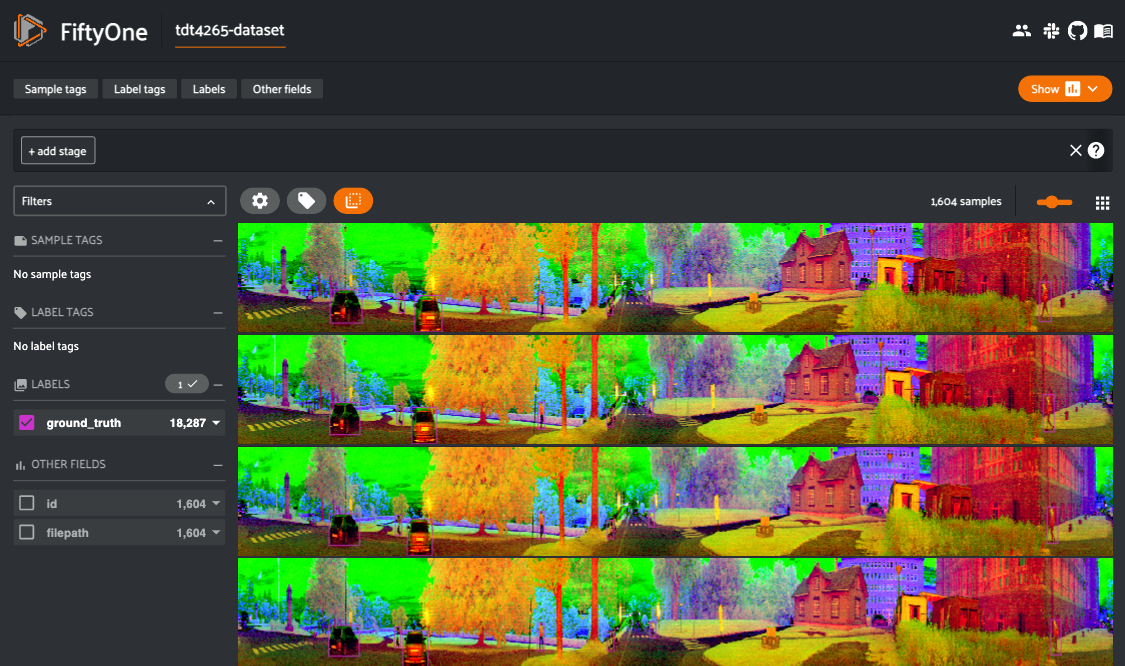

In [5]:
# Start session
session = fo.launch_app(dataset)


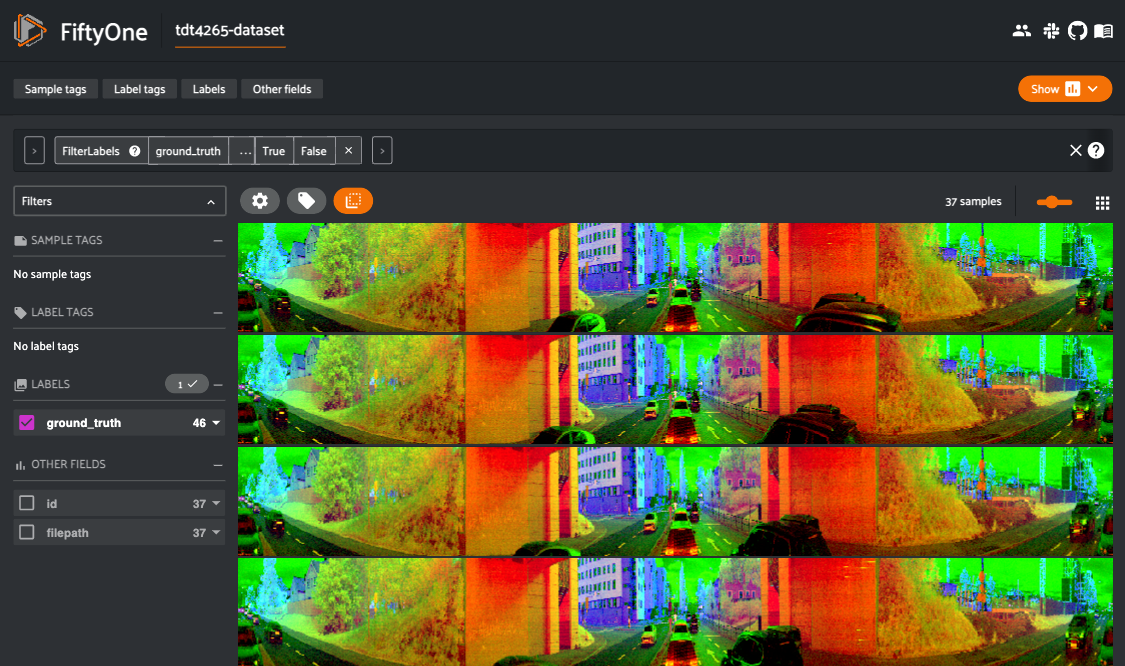

In [6]:
# Filter to only view small objects
# Bboxes are in [top-left-x, top-left-y, width, height] format
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

small_obj_view = dataset.filter_labels(
  "ground_truth",
  bbox_area < 0.0001,
)

session.view = small_obj_view

In the session above we see how there exists outliers like the car labeled at as low as three to four pixels. This is clearly either a mistake or impossible for a model to recognize. If there are too many examples like this then it will be difficult for a model to train on this dataset and learn the proper intra-class variance of a car because it can produce false positives based on this.


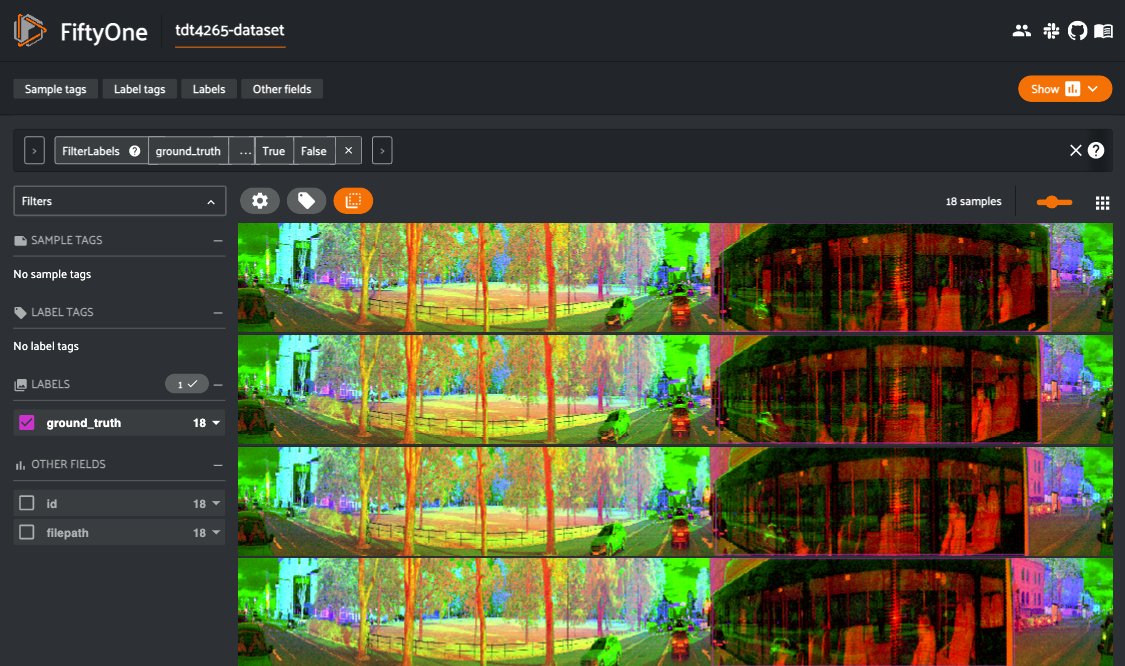

In [7]:
# Filter to only view big objects
big_obj_view = dataset.filter_labels(
  "ground_truth",
  bbox_area > 0.3,
)

session.view = big_obj_view

On the opposite side we see some examples of the largest objects in the dataset. There is no problem for the human eye to understand what these objects are labeled as (bus and truck). However, these samples would impose a high intra-class variability on certain objects for a model to capture. Even more so, is the number of samples like this sufficient to represent the intra-class variability of these objects? Combind with the low frequency of these objects as well, we assume there is a need for augmentation here to improve model performance on predicting these objects well. 

### Object statistics

#TODO: Calculate object size data for each class? Or do we have enough?

#TODO: Mean area of bounding box per category Figure?

#TODO: Intra- and inter-class variability - We could do several of the current analyses on individual classes.

#TODO: Histogram of objects aspect ratios in the dataset? By label as well?

In [10]:
# Convert to ground truth patches
gt_patches = dataset.to_patches("ground_truth")

# View patches in the App
# session.view = gt_patches

In [14]:
# Export object patches as classification dataset
gt_patches.export(
    export_dir="/tmp/quickstart/detections",
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth",
)

Directory '/tmp/quickstart/detections' already exists; export will be merged with existing files
Dataset exporter expects labels in <class 'fiftyone.core.labels.Detections'> format, but found <class 'fiftyone.core.labels.Detection'>. Wrapping field 'ground_truth' as single-label lists...
 100% |█████████████| 18287/18287 [12.8s elapsed, 0s remaining, 1.5K samples/s]       


In [16]:
objects = fo.Dataset.from_dir(
    dataset_dir='/tmp/quickstart/detections',
    dataset_type=fo.types.COCODetectionDataset,
    name='tdt4265-objects'
)

 100% |█████████████| 18287/18287 [11.4s elapsed, 0s remaining, 1.6K samples/s]      



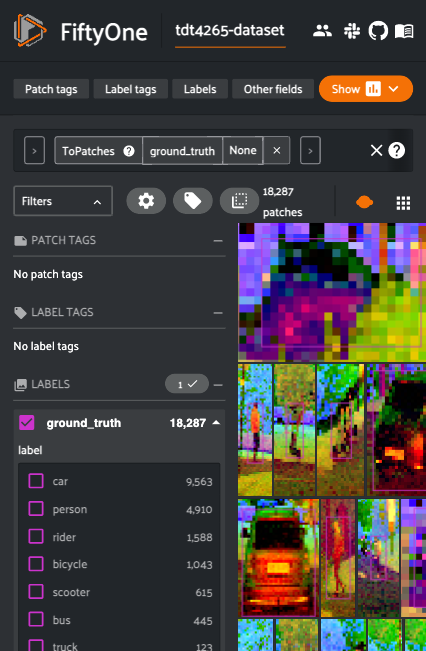

In [25]:
session.view = gt_patches

In [68]:
# expr = F("bounding_box")[2] * F("bounding_box")[3]
# map = F("detections").map(

# )
# c = objects.mean("ground_truth", expr)
# c = objects.std()
# c = objects.

# Calculate mean and std of bboxes area for each class
# for label in classes:
#     print(label)
#     expr = F("bounding_box")[2] * F("bounding_box")[3]
#     mean = objects.mean("ground_truth", expr, label=label)
#     std = objects.std("ground_truth", expr, label=label)
#     print(mean)
#     print(std)
#     print()

classes = dataset.get_classes("ground_truth")[1:]

# key: class_name, value: [mean, std]
object_statistics = {}
s = 0

for label in classes:
    filtered_objects_view = objects.filter_labels("ground_truth", (F("label") == label))
    for sample in filtered_objects_view:
        print(sample)
        break
    break
    l = len(filtered_objects_view)
    s += l
    print(f'{label}: {l}')
    filtered_objects_view = None


AttributeError: SampleView has no field 'detections'

### Uniqueness

The fiftyone app allows calculating something called uniqueness for each sample in the dataset. From their [documentation](https://voxel51.com/docs/fiftyone/tutorials/uniqueness.html):

>During model training, the best results will be seen when training on unique data samples. For example, finding and removing similar samples in your dataset can avoid accidental concept imbalance that can bias the learning of your model. Or, if duplicate or near-duplicate data is present in both training and validation/test splits, evaluation results may not be reliable. Just to name a few.

The aim is therefore to use FiftyOne to automatically find and remove near-duplicate images in our dataset and recommend the most unique samples in the data. This enables us to start model training right off with a higher-quality bootstrapped training set.

The uniqueness is calculated as a

In [ ]:
# Find most unique samples in dataset
fob.compute_uniqueness(dataset)

Computing embeddings...
 100% |███████████████| 1604/1604 [37.5s elapsed, 0s remaining, 42.1 samples/s]      
Computing uniqueness...
Uniqueness computation complete


In [ ]:
dups_view = dataset.sort_by("uniqueness")

session.view = dups_view

Here we see that the uniqueness calculation picked up samples which are stationary iamges and contain little variation. Hence, the uniqueness score is low. However, they are still not duplicates as the objects in the background are moving. We will therefore not be removing images based on low uniqueness score.

### Visual similarity

How can visual simiarlity be used in practice? A common pattern is to mine your dataset for similar examples to certain images or object patches of interest, e.g., those that represent failure modes of a model that need to be studied in more detail or underrepresented classes that need more training examples.

Here are a few of the many possible applications:
 * Identifying failure patterns of a model
 * Finding examples of target scenarios in your data lake
 * Mining hard examples for your evaluation pipeline
 * Recommending samples from your data lake for classes that need additional training data
 * Pruning near-duplicate images from your training dataset

In [ ]:
# Index images by similarity
fob.compute_similarity(dataset, brain_key="image_sim")

 100% |████|  108.4Mb/108.4Mb [1.1s elapsed, 0s remaining, 100.9Mb/s]        
Computing embeddings...
 100% |███████████████| 1604/1604 [5.4m elapsed, 0s remaining, 4.9 samples/s]       


Generating index...
Index complete



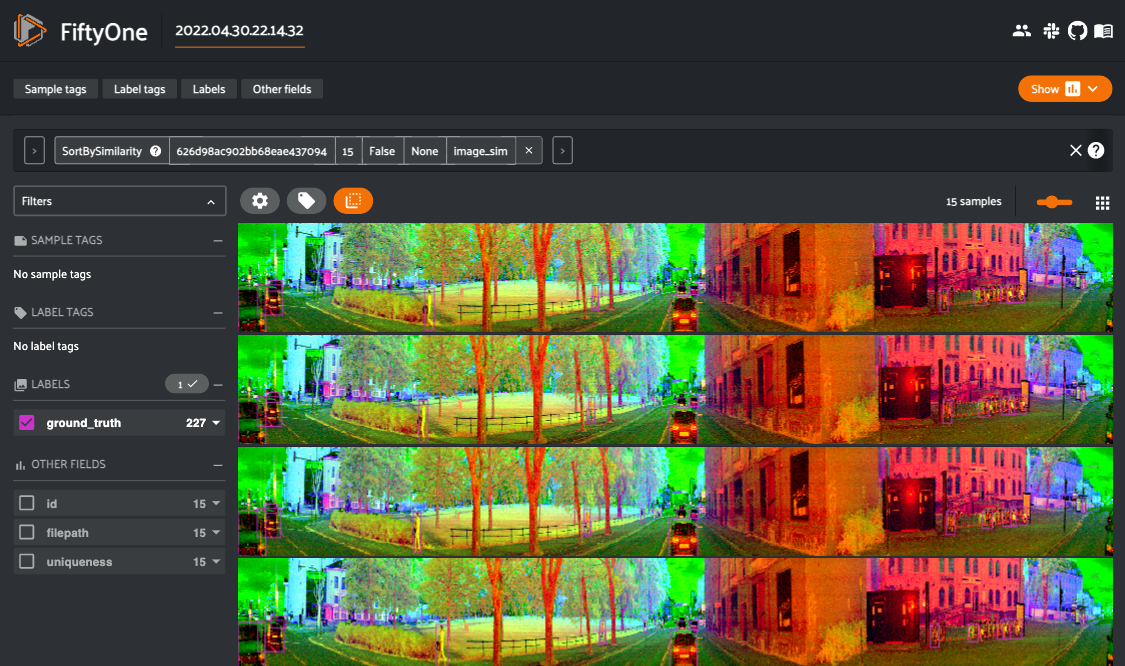

In [ ]:
# Choose a random image from the dataset
query_id = dataset.take(1).first().id

# Programmatically construct a view containing the 15 most similar images
view = dataset.sort_by_similarity(query_id, k=15, brain_key="image_sim")

# View results in App
session.view = view

### Visuaizing Embeddings

Since all images are equal and the training dataset is small, we pass the images themselves directly to the dimensionality reduction method and try to compute a visualization of the image embeddings.

The dimensionality reduction method we use is t-SNE.

In [ ]:
dataset_train = dataset.match_tags("train")

In [ ]:
print(dataset_fo_train)

Dataset:     tdt4265-dataset
Media type:  image
Num samples: 0
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    uniqueness:   fiftyone.core.fields.FloatField
View stages:
    1. MatchTags(tags=['train'], bool=True)


In [ ]:
import cv2

# Construct a num_sample x num_pixels array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel() for f in dataset_fo.values("filepath")
])

print(embeddings.shape)

# Compute 2D representation
# results = fob.compute_visualization(
#     dataset_fo,
#     embeddings=embeddings,
#     num_dims=2,
#     method="umap",  # Can also use "umap", "tsne", "pca", or "manual"
#     brain_key=None,
#     verbose=True,
#     seed=0
# )

# print(type(results))
# print(results.points.shape)

NameError: name 'np' is not defined

In [ ]:
# Label `test` split samples by their ground truth label
# Mark all samples in `train` split as `unlabeled`
labels = dataset_fo.values("ground_truth", expr=F("$tags").contains("train").if_else(F("label"), "unlabeled"))
print(labels)

In [ ]:
# Plot embeddings colored by ground truth label
plot = results.visualize(labels="ground_truth.label")
plot.show(height=720)

# Attach plot to session
session.plots.attach(plot)

In [ ]:
# Visualizing uniqueness

# Compute embeddings via a pre-trained CIFAR-10 classifier
model = fbm.load_model("simple-resnet-cifar10")
embeddings = dataset.compute_embeddings(model, batch_size=16)

# Generate similarity index
results = fob.compute_similarity(
    dataset, embeddings=embeddings, brain_key="img_sim"
)

# Generate a 2D visualization
viz_results = fob.compute_visualization(
    dataset, embeddings=embeddings, brain_key="img_viz"
)

In [ ]:
# Use the similarity index to identify 500 maximally unique images
results.find_unique(500)
print(results.unique_ids[:5])

In [ ]:
# Visualize the unique images in embeddings space
plot = results.visualize_unique(visualization=viz_results)
plot.show(height=800, yaxis_scaleanchor="x")

In [ ]:
# Visualize the unique images in the App
unique_view = dataset.select(results.unique_ids)
session = fo.launch_app(view=unique_view)

In [ ]:
# Use the similarity index to identify the 1% of images that are least
# visually similar w.r.t. the other images
results.find_duplicates(fraction=0.01)

print(results.neighbors_map)

In [ ]:
duplicates_view = results.duplicates_view(
    type_field="dup_type",
    id_field="dup_id",
    dist_field="dup_dist",
)

session.view = duplicates_view

In [ ]:
# Index ground truth objects by similarity
fob.compute_similarity(
    dataset_fo, patches_field="ground_truth", brain_key="gt_sim"
)

Computing patch embeddings...
   0% ||--------------|    0/1604 [39.7ms elapsed, ? remaining, ? samples/s] 

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


 100% |███████████████| 1604/1604 [21.8m elapsed, 0s remaining, 4.4 samples/s]      



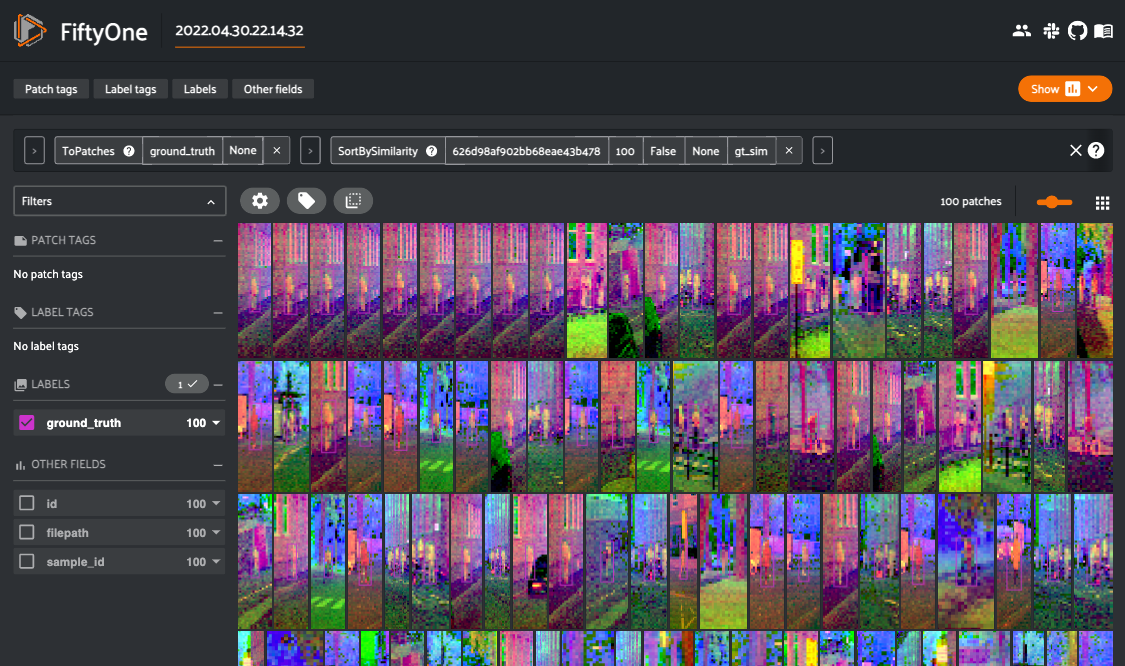

In [ ]:
# Convert to patches view
patches = dataset_fo.to_patches("ground_truth")

# Choose a random patch object from the dataset
query_id = patches.take(1).first().id

# Programmatically construct a view containing the 100 most similar objects
view = patches.sort_by_similarity(query_id, k=100, brain_key="gt_sim")

# View results in App
session.view = view

In [ ]:
# Find sample hardness

fob.compute_hardness(dataset_fo, "predictions")